In [ ]:
!source ~/.zshrc

In [1]:
import os
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rtree
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
import pandas_profiling

# Establish SodaPy connection
# Establish env variables
username = os.getenv('soc_user')
password = os.getenv('soc_pass')
token = os.getenv('soc_app_token')

# Authenticate client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org", 
                 token, 
                 username=username, 
                 password=password,
                timeout=25)


In [2]:
# Read in neighborhoods
#divvy_stations = gpd.read_file('data/divvy_stations.csv')

chicago = gpd.read_file("data/Boundaries - Community Areas (current)", crs = {'init': 'epsg:4326'})

# Pull Divvy station through socrata API
station_data = client.get('bk89-9dk7')


In [3]:
# Create Pandas DF to fix long & lat
divvy_data = pd.DataFrame(station_data)

divvy_data['longitude'] = divvy_data['longitude'].apply(lambda x: float(x))
divvy_data['latitude'] = divvy_data['latitude'].apply(lambda x: float(x))

In [4]:
# Move Divvy Station data to GeoDataFrame

all_divvy_stations = gpd.GeoDataFrame(divvy_data, geometry = gpd.points_from_xy(divvy_data['longitude'], divvy_data['latitude']))

# Rename columns
all_divvy_stations.rename(columns={':@computed_region_awaf_s7ux':'Historical Wards 2003-2015',
                              ':@computed_region_6mkv_f3dw':'Zip Codes',
                              ':@computed_region_vrxf_vc4k':'Community Areas',
                              ':@computed_region_bdys_3d7i':'Census Tracts',
                              ':@computed_region_43wa_7qmu':'Wards'},
                     inplace=True)

all_divvy_stations = all_divvy_stations.drop(['Zip Codes', 'location'], axis=1)
all_divvy_stations.info()

all_divvy_stations.crs = {'init':'epsg:4326'}


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   station_name                595 non-null    object  
 1   Wards                       581 non-null    object  
 2   total_docks                 595 non-null    object  
 3   latitude                    595 non-null    float64 
 4   Historical Wards 2003-2015  581 non-null    object  
 5   longitude                   595 non-null    float64 
 6   Census Tracts               581 non-null    object  
 7   status                      595 non-null    object  
 8   Community Areas             581 non-null    object  
 9   docks_in_service            595 non-null    object  
 10  id                          595 non-null    object  
 11  geometry                    595 non-null    geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 55.9+ KB


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
# Inspect Chicago Ward Data
chicago.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   area        77 non-null     float64 
 1   area_num_1  77 non-null     object  
 2   area_numbe  77 non-null     object  
 3   comarea     77 non-null     float64 
 4   comarea_id  77 non-null     float64 
 5   community   77 non-null     object  
 6   perimeter   77 non-null     float64 
 7   shape_area  77 non-null     float64 
 8   shape_len   77 non-null     float64 
 9   geometry    77 non-null     geometry
dtypes: float64(6), geometry(1), object(3)
memory usage: 6.1+ KB


In [6]:
# Define Chicago Side Groups

far_north_side = ['76', '9', '10', '11', '12', '13', '14', '4', '2', '3', '77', '1']
#far_north_side = [int(x) for x in far_north_side]

northwest_side = ['17', '18', '19', '20', '15', '16']
#northwest_side = [int(x) for x in northwest_side]

north_side = ['22', '21', '5', '6', '7']
#north_side = [int(x) for x in north_side]

west_side = ['25', '26', '27', '23', '24', '28', '29', '31', '30']
#west_side = [int(x) for x in west_side]

central = ['33', '32', '8']
#central = [int(x) for x in central]

south_side = ['60', '37', '34', '35', '36', '40', '41', '42', '69', '43', '38', '39']
#south_side = [int(x) for x in south_side]

southwest_side = ['56', '64', '65', '66', '67', '68', '62', '63', '61', '57', '58', '59']
#southwest_side = [int(x) for x in southwest_side]

far_southwest_side = ['74', '75', '72', '73', '71', '70']
#far_southwest_side = [int(x) for x in far_southwest_side]

far_south_side = ['55', '54', '51', '49', '53', '50', '44', '47', '45', '46', '48', '46', '52']
#far_south_side = [int(x) for x in far_south_side]

# All Wards List
#all_wards = far_north_side + northwest_side + north_side + west_side + central + south_side + far_southwest_side + southwest_side + far_south_side


In [7]:
# Define Function to Assign Groups

def assign_sides(ward):
    if ward in far_north_side:
        return "far north side"
    elif ward in northwest_side:
        return "northwest side"
    elif ward in north_side:
        return "north side"
    elif ward in west_side:
        return "west side"
    elif ward in central:
        return "loop"
    elif ward in south_side:
        return "south side"
    elif ward in southwest_side:
        return "southwest side"
    elif ward in far_southwest_side:
        return "far southwest side"
    elif ward in far_south_side:
        return "far south side"
    else:
        return "None"

In [8]:
def find_Polygon(x):
    dex =  chicago[chicago['geometry'].contains(x)].index.values[0]
    return chicago['area_num_1'][dex]
    

In [9]:
#Fix Data Types
divvy_stations = all_divvy_stations[all_divvy_stations['Wards'].isna()==False]
divvy_stations = divvy_stations.drop(['Census Tracts', 'Historical Wards 2003-2015'], axis=1)
divvy_stations['total_docks'] = divvy_stations['total_docks'].apply(lambda x: int(x))
divvy_stations['docks_in_service'] = divvy_stations['docks_in_service'].apply(lambda x: int(x))



In [10]:
chicago.crs={'init':'epsg:4326'}

print(divvy_stations.crs)
print("\n", chicago.crs)
    

+init=epsg:4326 +type=crs

 +init=epsg:4326 +type=crs


In [11]:
chicago

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


In [12]:
### Check out website: https://stackoverflow.com/questions/59461445/geopandas-contains-working-for-one-point-but-not-many

In [13]:
divvy_stations['fix_area'] = divvy_stations.geometry.apply(lambda x: find_Polygon(x))

In [14]:
divvy_stations

,station_name,Wards,total_docks,latitude,longitude,status,Community Areas,docks_in_service,id,geometry,fix_area
0,Clinton St & Polk St,26,15,41.871467,-87.640949,In Service,29,15,103,POINT (-87.64095 41.87147),28
1,Jeffery Blvd & 71st St,33,11,41.766638,-87.576450,In Service,39,11,11,POINT (-87.57645 41.76664),43
2,South Shore Dr & 71st St,33,15,41.766409,-87.565688,In Service,39,15,12,POINT (-87.56569 41.76641),43
3,Kingsbury St & Kinzie St,36,31,41.889177,-87.638506,In Service,37,31,133,POINT (-87.63851 41.88918),8
4,Peoria St & Jackson Blvd,26,19,41.877642,-87.649618,In Service,29,19,134,POINT (-87.64962 41.87764),28
...,...,...,...,...,...,...,...,...,...,...,...
590,Halsted St & North Branch St,46,15,41.899368,-87.648480,In Service,37,15,365,POINT (-87.64848 41.89937),8
591,Wood St & 35th St,1,11,41.830105,-87.670298,In Service,56,11,369,POINT (-87.67030 41.83010),59
592,Clark St & Lake St,36,27,41.886021,-87.630876,In Service,38,27,38,POINT (-87.63088 41.88602),32
593,Calumet Ave & 51st St,9,11,41.802295,-87.618054,In Service,4,11,415,POINT (-87.61805 41.80229),38


In [15]:
# Assign Groups
chicago['side'] = chicago['area_num_1'].apply(lambda x: assign_sides(x))
divvy_stations['side'] = divvy_stations['fix_area'].apply(lambda x: assign_sides(x))

# Drop Areas not in City
chicago = chicago[chicago['side']!='None']
divvy_stations

,station_name,Wards,total_docks,latitude,longitude,status,Community Areas,docks_in_service,id,geometry,fix_area,side
0,Clinton St & Polk St,26,15,41.871467,-87.640949,In Service,29,15,103,POINT (-87.64095 41.87147),28,west side
1,Jeffery Blvd & 71st St,33,11,41.766638,-87.576450,In Service,39,11,11,POINT (-87.57645 41.76664),43,south side
2,South Shore Dr & 71st St,33,15,41.766409,-87.565688,In Service,39,15,12,POINT (-87.56569 41.76641),43,south side
3,Kingsbury St & Kinzie St,36,31,41.889177,-87.638506,In Service,37,31,133,POINT (-87.63851 41.88918),8,loop
4,Peoria St & Jackson Blvd,26,19,41.877642,-87.649618,In Service,29,19,134,POINT (-87.64962 41.87764),28,west side
...,...,...,...,...,...,...,...,...,...,...,...,...
590,Halsted St & North Branch St,46,15,41.899368,-87.648480,In Service,37,15,365,POINT (-87.64848 41.89937),8,loop
591,Wood St & 35th St,1,11,41.830105,-87.670298,In Service,56,11,369,POINT (-87.67030 41.83010),59,southwest side
592,Clark St & Lake St,36,27,41.886021,-87.630876,In Service,38,27,38,POINT (-87.63088 41.88602),32,loop
593,Calumet Ave & 51st St,9,11,41.802295,-87.618054,In Service,4,11,415,POINT (-87.61805 41.80229),38,south side


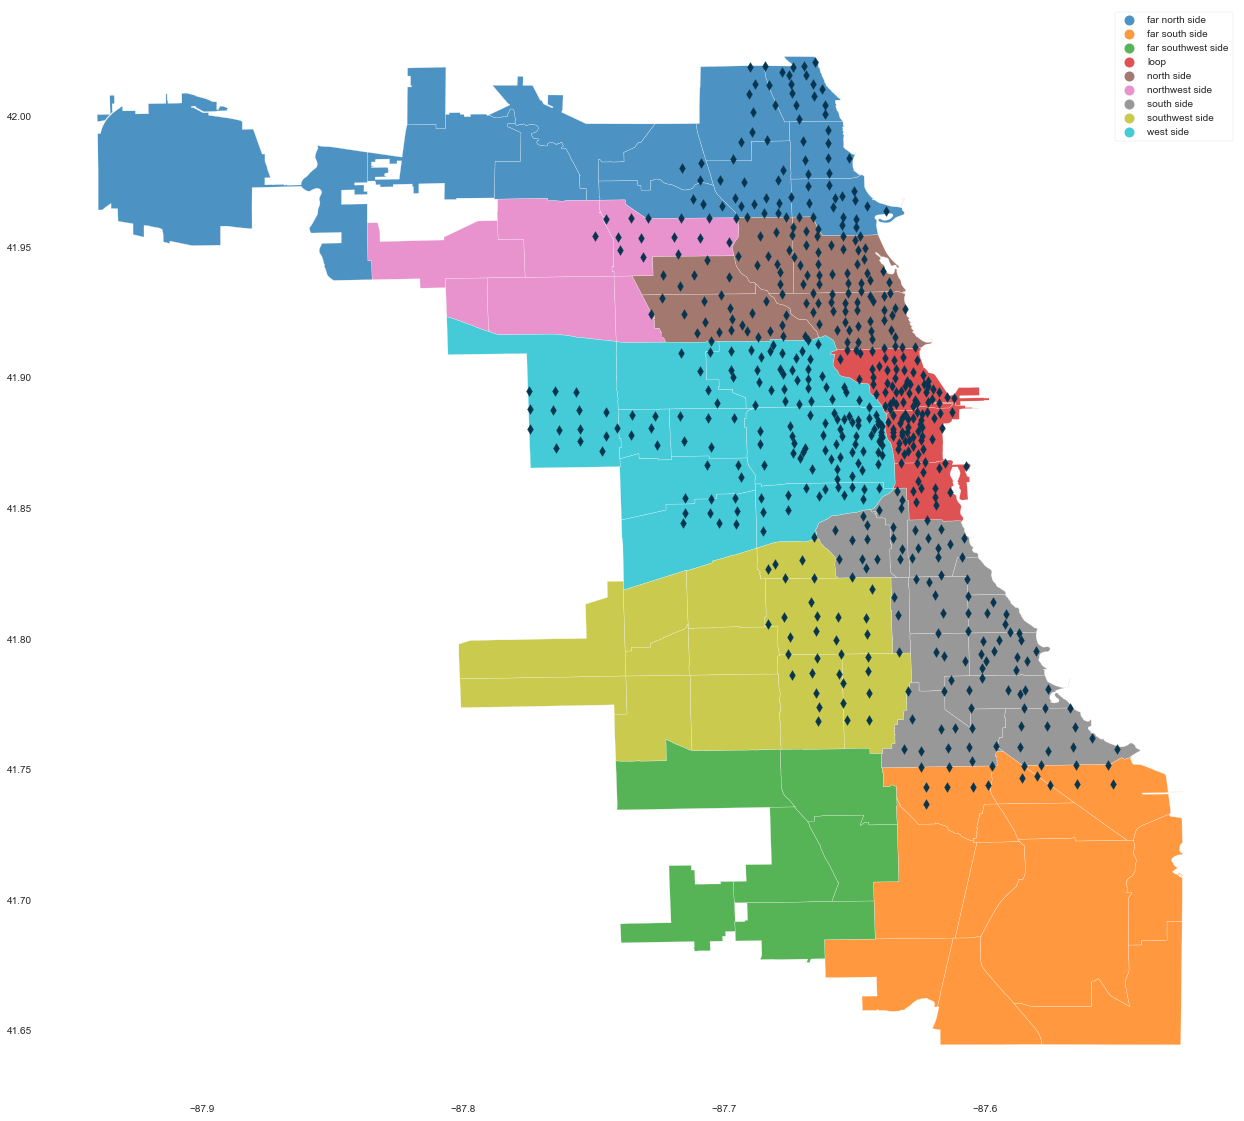

In [16]:
base = chicago.plot(figsize=(30,20), alpha=0.8, column='side', legend = True)

divvy_stations.plot(ax=base, figsize=(30,20), marker ='d', color='#063550')

In [17]:
# High Level Analysis on Divvy stations by general area of Chicago
station_agg = divvy_stations.groupby(['side']).agg({'id':'count', 
                                                'total_docks':'sum',
                                                'docks_in_service':'sum'})
station_agg.sort_values('id', ascending=False)

,id,total_docks,docks_in_service
side,,,
west side,143,2381,2373
north side,109,1967,1967
loop,105,2651,2651
south side,93,1275,1275
far north side,69,1127,1127
southwest side,33,351,351
far south side,15,161,161
northwest side,14,194,194


,station_name,Wards,total_docks,latitude,longitude,status,Community Areas,docks_in_service,id,geometry,fix_area,side
0,Clinton St & Polk St,26,15,41.871467,-87.640949,In Service,29,15,103,POINT (-87.64095 41.87147),28,west side
4,Peoria St & Jackson Blvd,26,19,41.877642,-87.649618,In Service,29,19,134,POINT (-87.64962 41.87764),28,west side
11,Elizabeth (May) St & Fulton St,46,15,41.886616,-87.658040,In Service,29,15,217,POINT (-87.65804 41.88662),28,west side
38,Western Ave & Monroe St,46,15,41.879788,-87.686113,In Service,29,15,381,POINT (-87.68611 41.87979),28,west side
40,Western Ave & Congress Pkwy,23,19,41.874749,-87.686445,In Service,29,19,382,POINT (-87.68645 41.87475),28,west side
128,Clinton St & Roosevelt Rd,48,15,41.867118,-87.641088,In Service,29,15,57,POINT (-87.64109 41.86712),28,west side
131,Clinton St & Jackson Blvd,36,23,41.878116,-87.639838,In Service,29,23,638,POINT (-87.63984 41.87812),28,west side
137,Morgan St & Lake St,46,23,41.885483,-87.652305,In Service,29,23,71,POINT (-87.65230 41.88548),28,west side
144,Ogden Ave & Roosevelt Rd,23,19,41.866501,-87.684697,In Service,29,19,434,POINT (-87.68470 41.86650),28,west side
150,Desplaines St & Randolph St,36,23,41.884616,-87.644571,In Service,29,23,96,POINT (-87.64457 41.88462),28,west side
